# Clasificación de Sentimientos Utilizando LSTM Bidireccional

Realizado por:
- Paula Monge
- Emmanuel Zúñiga

Trabajo de Invetigación del Curso:
- Investigación en Ciencias de la Computación

Tema de Investigación:
- Aprendizaje Automático en la clasificación de Sentimientos en Twitter: Comparación de los Algoritmos de LSTM Bidireccional, Regresión Logistica y Naïve Bayes

## Importación de librerias 📚

In [ ]:

!pip install tensorflow
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow.keras.utils as ku
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from google.colab import drive
from sklearn.preprocessing import LabelEncoder

## Carga del dataset 📅

In [ ]:

# El dataset en cuestión contiene datos sobre tweets en diferentes idiomas, pero nos interesa utilizar solo
# los que se encuentran en español.
tweets = pd.read_csv('https://raw.githubusercontent.com/Emmazch22/Paula_y_Emmanuel_CI0134/main/Datasets/clean_dataset.csv')

In [ ]:
tweets.head(10)

,Unnamed: 0.1,Unnamed: 0,Text,Label
0,0,36205,es lo menos,0
1,1,105993,jaja me acoste a eso de las 3 de la manana o a...,0
2,2,77438,manana ire solari no mas,0
3,3,93306,tomate un acetaminofen amor,0
4,4,83950,lo siento,0
5,5,61508,o sea iba a quedar feo como mujer,0
6,6,59726,ademas de tener insomnio tengo hambre,0
7,7,39053,a mi me salio una en ese mismo lugar,0
8,8,49669,que alguien me hablee lt 3 lt 3 me aburro,0
9,9,83894,ni me daras nada,0


In [ ]:
tweets.shape

(110720, 4)

In [ ]:
tweets.shape

(110720, 4)

In [ ]:
tweets = tweets.dropna()
print(tweets.shape)

(110680, 4)


## Creación de sets de entrenamiento y prueba 📅

Para los datos de entrenamiento y prueba se utiliza una proporción de 80/20 con respecto al dataset original.

In [ ]:
train_pct = 0.8
train_size = round(len(tweets) * train_pct)

train_data = tweets.iloc[:train_size]
test_data = tweets.iloc[train_size:]

test_data = test_data.drop('Label', axis=1)

In [ ]:
train_data.head(10)

,Unnamed: 0.1,Unnamed: 0,Text,Label
0,0,36205,es lo menos,0
1,1,105993,jaja me acoste a eso de las 3 de la manana o a...,0
2,2,77438,manana ire solari no mas,0
3,3,93306,tomate un acetaminofen amor,0
4,4,83950,lo siento,0
5,5,61508,o sea iba a quedar feo como mujer,0
6,6,59726,ademas de tener insomnio tengo hambre,0
7,7,39053,a mi me salio una en ese mismo lugar,0
8,8,49669,que alguien me hablee lt 3 lt 3 me aburro,0
9,9,83894,ni me daras nada,0


In [ ]:
test_data.head(10)

,Unnamed: 0.1,Unnamed: 0,Text
88574,88574,23161,si wiiii pero nada de chela bueno tal vez
88575,88575,18658,una foto del concierto genial concierto todo m...
88576,88576,9178,eliminare esa opcion
88577,88577,37786,ale feliz domingo un besazo chica
88578,88578,34967,gracias por seguirme en breve te devuelvo foll...
88579,88579,30608,gracias por seguirme en breve te devuelvo foll...
88580,88580,28578,abri 120 sobres hoy 7000 oro ahorrado y 50 de ...
88581,88581,39433,gracias por seguirme en breve te devuelvo foll...
88582,88582,31732,este bebe y este cachorrito nacieron el mismo ...
88583,88583,51120,el vecino se parece a daguito cuando dejaba la...


## Construcción del modelo - LSTM Bidireccional 🧠

In [ ]:

import nltk
import seaborn as sns
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#stemming and removing stop-words
stemmer = PorterStemmer()

def stem_remove_sw(df, text_col):
    corpus = []
    reviews = df[text_col].apply(str).str.split()
    reviews = reviews.apply(lambda review: [stemmer.stem(word) for word in review if word not in stop_words])
    reviews = reviews.apply(lambda review: " ".join(review))
    corpus = reviews.tolist()
    return corpus

train_corpus = stem_remove_sw(train_data, 'Text')
train_corpus[0]

'meno'

In [ ]:
#tfidf vectorizer
tfv = TfidfVectorizer()
X = tfv.fit_transform(train_corpus).toarray()
Y = train_data["Label"]

In [ ]:
test_size = int(len(X) * 0.2)
# Mezcla los datos
##X, y = shuffle(X, y, random_state=1)
# Divide los datos en conjuntos de entrenamiento y prueba
X_test = X[:test_size]
X_train = X[test_size:]
y_test = Y[:test_size]
y_train = Y[test_size:]

In [ ]:
print(len(set(" ".join(train_corpus).split())))

48591


In [ ]:
voc_size = 20000
onehot_repr=[one_hot(words,voc_size)for words in train_corpus] 
onehot_repr[0]

[10818]

<ipython-input-17-2e3f922053d5>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lens)


<Axes: xlabel='Text', ylabel='Density'>

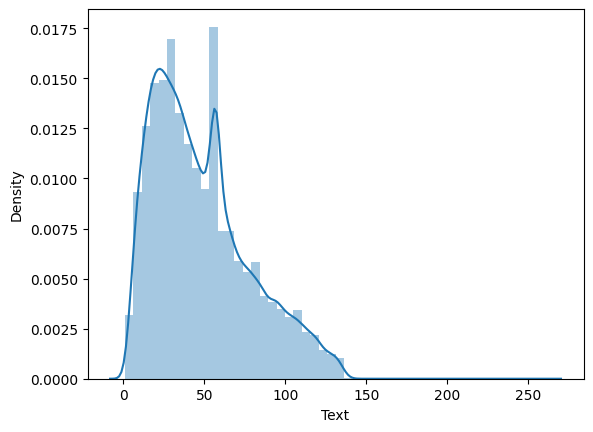

In [ ]:
# finding length of tweets
lens = train_data['Text'].str.len()
sns.distplot(lens)

In [ ]:
np.median(train_data['Text'].str.len())

42.0

In [ ]:
sent_length=50
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0 10818]


In [ ]:
## Creating a bidirectional LSTM model

from keras.optimizers import Adam

lr = 0.01  # especifica la tasa de aprendizaje deseada
optimizer = Adam(lr=lr)  # crea un optimizador Adam con la tasa de aprendizaje especificada


embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(120)))
model1.add(Dropout(0.5))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
print(model1.summary())

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 40)            800000    
                                                                 
 bidirectional (Bidirectiona  (None, 240)              154560    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 240)               0         
                                                                 
 dense (Dense)               (None, 1)                 241       
                                                                 
Total params: 954,801
Trainable params: 954,801
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
X_lstm=np.array(embedded_docs)
Y_lstm = Y

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_lstm, Y_lstm, test_size=0.33, random_state=42)

In [ ]:
model1.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=64)

Epoch 1/20
927/927 [==============================] - 19s 12ms/step - loss: 0.5145 - accuracy: 0.7467 - val_loss: 0.4810 - val_accuracy: 0.7661
Epoch 2/20
927/927 [==============================] - 11s 12ms/step - loss: 0.4139 - accuracy: 0.8093 - val_loss: 0.5109 - val_accuracy: 0.7634
Epoch 3/20
927/927 [==============================] - 9s 10ms/step - loss: 0.3409 - accuracy: 0.8473 - val_loss: 0.5879 - val_accuracy: 0.7568
Epoch 4/20
927/927 [==============================] - 11s 12ms/step - loss: 0.2904 - accuracy: 0.8711 - val_loss: 0.6231 - val_accuracy: 0.7459
Epoch 5/20
927/927 [==============================] - 10s 11ms/step - loss: 0.2548 - accuracy: 0.8867 - val_loss: 0.7379 - val_accuracy: 0.7435
Epoch 6/20
927/927 [==============================] - 10s 10ms/step - loss: 0.2295 - accuracy: 0.8978 - val_loss: 0.7869 - val_accuracy: 0.7435
Epoch 7/20
927/927 [==============================] - 9s 10ms/step - loss: 0.2175 - accuracy: 0.9030 - val_loss: 0.8353 - val_accuracy: 0

In [ ]:
y_pred_lstm=model1.predict(x_test)
y_pred_lstm = np.round(abs(y_pred_lstm))
print("Accuracy Score: ", accuracy_score(y_test, y_pred_lstm))
print("Confusion Matrix: \n", confusion_matrix(y_test,y_pred_lstm))
print(classification_report(y_test,y_pred_lstm))

914/914 [==============================] - 4s 3ms/step
Accuracy Score:  0.7316221765913757
Confusion Matrix: 
 [[14733  3593]
 [ 4249  6645]]
              precision    recall  f1-score   support

           0       0.78      0.80      0.79     18326
           1       0.65      0.61      0.63     10894

    accuracy                           0.73     29220
   macro avg       0.71      0.71      0.71     29220
weighted avg       0.73      0.73      0.73     29220



Text(70.72222222222221, 0.5, 'Predicted label')

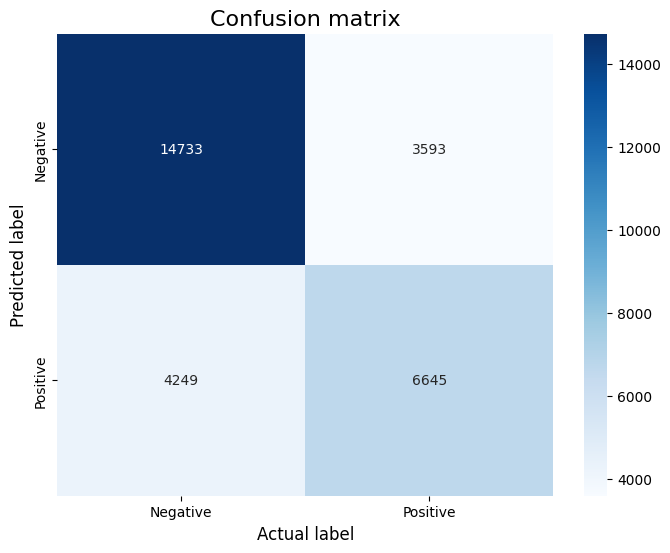

In [ ]:
import seaborn as sns    

sentiment_classes = ['Negative', 'Positive']

cm = confusion_matrix(y_test,y_pred_lstm)
# plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)